# Proyecto de Clasificación de Sitios Phishing

## Análisis y Clasificación de Sitios Web Phishing usando Naive Bayes

Este notebook implementa un sistema completo de clasificación para detectar sitios web de phishing utilizando el algoritmo Gaussian Naive Bayes.

**Objetivo**: Entrenar un modelo de clasificación que pueda distinguir entre sitios web legítimos (-1) y sitios de phishing (1) basándose en 30 características específicas.

**Dataset**: Training Dataset.arff - contiene 31 columnas (30 features + 1 Result)

**Fases del proyecto**:
1. Análisis inicial y carga de datos
2. División de datos (70/15/15)
3. Modelo base sin optimización
4. Optimización de hiperparámetros
5. Comparación de resultados


## 1. Configuración Inicial e Importación de Librerías

En esta sección importamos todas las librerías necesarias y configuramos la semilla aleatoria para garantizar la reproducibilidad de los resultados.


In [ ]:
# ============================================
# Importación de Librerías
# ============================================

# Manejo de datos
import pandas as pd
import numpy as np
from scipy.io import arff

# División y validación de datos
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Modelo de clasificación
from sklearn.naive_bayes import GaussianNB

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
import warnings
warnings.filterwarnings('ignore')

# ============================================
# Configuración de Reproducibilidad
# ============================================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías importadas correctamente")
print(f"✓ Semilla aleatoria configurada: {RANDOM_STATE}")


✓ Librerías importadas correctamente
✓ Semilla aleatoria configurada: 42


## 2. Fase 1 y 2: Carga y Análisis del Dataset

En esta fase realizamos:
1. Carga del archivo ARFF
2. Verificación de la estructura de datos (31 columnas: 30 features + Result)
3. Verificación de tipos de datos numéricos
4. Confirmación de ausencia de valores nulos
5. Análisis de la distribución de clases


In [ ]:
# ============================================
# Carga del Dataset ARFF
# ============================================

# Cargar el archivo ARFF
archivo_dataset = '../../phishing+websites/Training Dataset.arff'
data, meta = arff.loadarff(archivo_dataset)

# Convertir a DataFrame de pandas
df = pd.DataFrame(data)

# Convertir bytes a strings si es necesario y ajustar tipos
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str)

# Convertir todas las columnas a tipo numérico
df = df.apply(pd.to_numeric, errors='coerce')

print("=" * 60)
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"\n📊 Dimensiones del dataset: {df.shape}")
print(f"   - Filas (muestras): {df.shape[0]:,}")
print(f"   - Columnas (features + target): {df.shape[1]}")
print(f"\n✓ Features: 30")
print(f"✓ Variable objetivo: Result (columna 31)")

# Mostrar primeras filas
print("\n" + "=" * 60)
print("PRIMERAS 5 FILAS DEL DATASET")
print("=" * 60)
display(df.head())


INFORMACIÓN DEL DATASET

📊 Dimensiones del dataset: (11055, 31)
   - Filas (muestras): 11,055
   - Columnas (features + target): 31

✓ Features: 30
✓ Variable objetivo: Result (columna 31)

PRIMERAS 5 FILAS DEL DATASET


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [ ]:
# ============================================
# Verificación de Tipos de Datos
# ============================================

print("=" * 60)
print("VERIFICACIÓN DE TIPOS DE DATOS")
print("=" * 60)

# Información de tipos
print("\nTipos de datos por columna:")
print(df.dtypes.value_counts())

# Verificar que Result tenga valores correctos
print(f"\n✓ Valores únicos en 'Result': {sorted(df['Result'].unique())}")
print(f"  Interpretación: 1 = Legítimo, -1 = Phishing")

# Asegurar que Result sea tipo int
df['Result'] = df['Result'].astype(int)

print(f"\n✓ Tipo de dato de Result: {df['Result'].dtype}")
print("✓ Todas las columnas son numéricas")


VERIFICACIÓN DE TIPOS DE DATOS

Tipos de datos por columna:
int64    31
Name: count, dtype: int64

✓ Valores únicos en 'Result': [np.int64(-1), np.int64(1)]
  Interpretación: 1 = Legítimo, -1 = Phishing

✓ Tipo de dato de Result: int64
✓ Todas las columnas son numéricas


In [ ]:
# ============================================
# Verificación de Valores Faltantes
# ============================================

print("=" * 60)
print("VERIFICACIÓN DE VALORES FALTANTES")
print("=" * 60)

valores_nulos = df.isnull().sum()
total_nulos = valores_nulos.sum()

print(f"\nTotal de valores nulos en el dataset: {total_nulos}")

if total_nulos == 0:
    print("✓ No hay valores faltantes en el dataset")
    print("✓ Los datos están completos y listos para el modelado")
else:
    print("\n⚠ Se encontraron valores nulos:")
    print(valores_nulos[valores_nulos > 0])


VERIFICACIÓN DE VALORES FALTANTES

Total de valores nulos en el dataset: 0
✓ No hay valores faltantes en el dataset
✓ Los datos están completos y listos para el modelado


ANÁLISIS DE DISTRIBUCIÓN DE CLASES

Distribución de la variable objetivo (Result):
Result
-1    4898
 1    6157
Name: count, dtype: int64

Porcentajes:
  Phishing (-1): 44.31%
  Legítimo (1): 55.69%


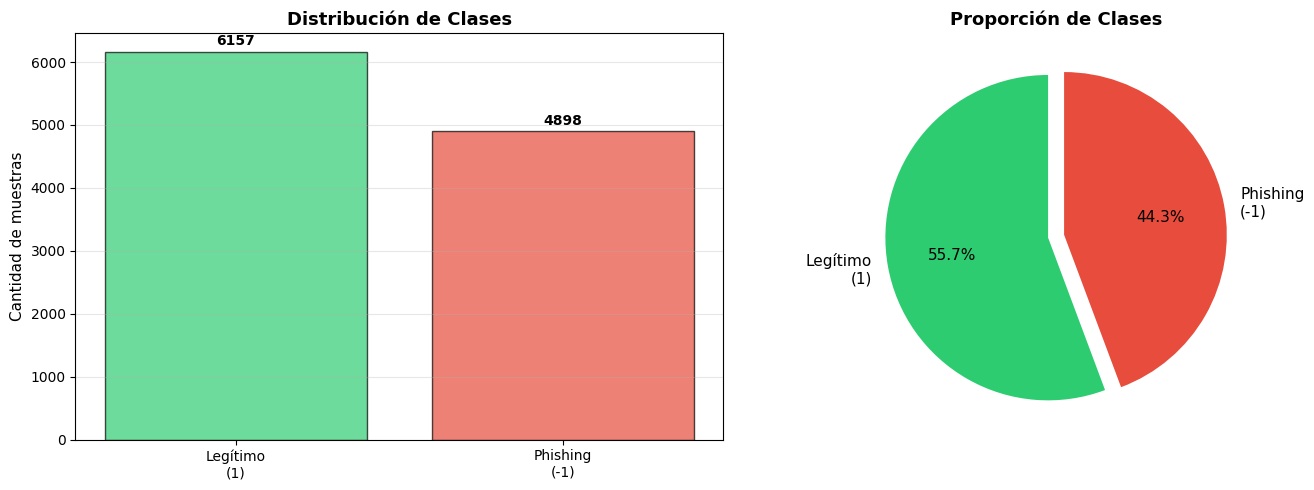


📊 Ratio de balance: 0.8
   (Clase minoritaria / Clase mayoritaria)

✓ Las clases están BALANCEADAS (ratio ≥ 0.8)
  • La clase minoritaria tiene al menos el 80% del tamaño de la mayoritaria
  • No se requieren técnicas especiales de balanceo
  • La división estratificada es suficiente


In [ ]:
# ============================================
# Análisis de Distribución de Clases
# ============================================

print("=" * 60)
print("ANÁLISIS DE DISTRIBUCIÓN DE CLASES")
print("=" * 60)

# Contar distribución (serie ordenada por índice: -1, 1)
distribucion_series = df['Result'].value_counts().sort_index()
print("\nDistribución de la variable objetivo (Result):")
print(distribucion_series)

# Calcular porcentajes (también ordenado por índice)
porcentajes = df['Result'].value_counts(normalize=True).sort_index() * 100
print("\nPorcentajes:")
for valor, porcentaje in porcentajes.items():
    etiqueta = "Legítimo" if valor == 1 else "Phishing"
    print(f"  {etiqueta} ({valor}): {porcentaje:.2f}%")

# Preparar datos para gráficos asegurando el orden de etiquetas
count_legit   = int(distribucion_series.get( 1, 0))
count_phish   = int(distribucion_series.get(-1, 0))
counts_plot   = [count_legit, count_phish]
etiquetas     = ['Legítimo\n(1)', 'Phishing\n(-1)']
colores       = ['#2ecc71', '#e74c3c']

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(etiquetas, counts_plot, color=colores, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Cantidad de muestras', fontsize=11)
axes[0].set_title('Distribución de Clases', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(counts_plot):
    axes[0].text(i, v + max(1, int(0.01 * max(counts_plot) if max(counts_plot) else 1)), str(v),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico de torta
axes[1].pie(counts_plot, labels=etiquetas, colors=colores, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 11}, explode=(0.05, 0.05))
axes[1].set_title('Proporción de Clases', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Evaluación de balance
if (count_legit + count_phish) > 0 and min(count_legit, count_phish) > 0:
    ratio = round(min(count_legit, count_phish) / max(count_legit, count_phish), 2)
else:
    ratio = 0.0

print(f"\n📊 Ratio de balance: {ratio}")
print(f"   (Clase minoritaria / Clase mayoritaria)")

# Interpretación del ratio con niveles
if ratio >= 0.8:
    print("\n✓ Las clases están BALANCEADAS (ratio ≥ 0.8)")
    print("  • La clase minoritaria tiene al menos el 80% del tamaño de la mayoritaria")
    print("  • No se requieren técnicas especiales de balanceo")
    print("  • La división estratificada es suficiente")
elif ratio >= 0.5:
    print("\n⚠ DESBALANCE MODERADO (0.5 ≤ ratio < 0.8)")
    print("  • Considerar: pesos de clase o validación estratificada")
    print("  • Monitorear métricas en clases minoritarias")
else:
    print("\n❌ DESBALANCE SIGNIFICATIVO (ratio < 0.5)")
    print("  • Considerar técnicas de balanceo: SMOTE, undersampling")
    print("  • Usar métricas robustas: F1-score, AUC-ROC")
    print("  • Ajustar umbrales de clasificación")


In [ ]:
# ============================================
# Estadísticas Descriptivas
# ============================================

print("=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS DEL DATASET")
print("=" * 60)

print("\nResumen estadístico de todas las features:")
display(df.describe())

print("\n" + "=" * 60)
print("RESUMEN DE LA FASE 1 Y 2")
print("=" * 60)
print("✓ Dataset cargado y verificado exitosamente")
print("✓ 30 features numéricas + 1 variable objetivo (Result)")
print("✓ Sin valores faltantes")
print(f"✓ Clases balanceadas (ratio = {ratio:.2f})")
print("✓ Listo para la siguiente fase: División de datos")


ESTADÍSTICAS DESCRIPTIVAS DEL DATASET

Resumen estadístico de todas las features:


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



RESUMEN DE LA FASE 1 Y 2
✓ Dataset cargado y verificado exitosamente
✓ 30 features numéricas + 1 variable objetivo (Result)
✓ Sin valores faltantes
✓ Clases balanceadas (ratio = 0.80)
✓ Listo para la siguiente fase: División de datos


## 3. Fase 3: División de Datos (Estrategia 70/15/15)

En esta fase dividimos el dataset en tres conjuntos:
- **Entrenamiento (70%)**: Para entrenar los modelos
- **Validación (15%)**: Para evaluación intermedia y ajuste de hiperparámetros
- **Prueba (15%)**: Para evaluación final del desempeño

La división es **estratificada** para mantener la proporción original de clases en cada conjunto.


In [ ]:
# ============================================
# Separación de Features y Variable Objetivo
# ============================================

print("=" * 60)
print("SEPARACIÓN DE VARIABLES")
print("=" * 60)

# Separar features (X) y variable objetivo (y)
X = df.drop('Result', axis=1)
y = df['Result']

print(f"\n✓ Features (X): {X.shape}")
print(f"  - Número de features: {X.shape[1]}")
print(f"  - Número de muestras: {X.shape[0]:,}")

print(f"\n✓ Variable objetivo (y): {y.shape}")
print(f"  - Valores únicos: {sorted(y.unique())}")
print(f"  - Interpretación: -1 = Phishing (positiva), 1 = Legítimo")

print("\nNombres de las features:")
print(list(X.columns))


SEPARACIÓN DE VARIABLES

✓ Features (X): (11055, 30)
  - Número de features: 30
  - Número de muestras: 11,055

✓ Variable objetivo (y): (11055,)
  - Valores únicos: [np.int64(-1), np.int64(1)]
  - Interpretación: -1 = Phishing (positiva), 1 = Legítimo

Nombres de las features:
['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report']


In [ ]:
# ============================================
# División Estratificada 70/15/15
# ============================================

print("=" * 60)
print("DIVISIÓN ESTRATIFICADA DE DATOS")
print("=" * 60)

# Primera división: 70% train, 30% temporal (estratificada)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    stratify=y, 
    random_state=RANDOM_STATE
)

# Segunda división: 50% validación, 50% prueba del temporal (15% cada uno)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print("\n📊 Tamaños de los conjuntos:")
print(f"  - Entrenamiento: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Validación:    {X_val.shape[0]:,} muestras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  - Prueba:        {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  - Total:         {len(X):,} muestras")

print("\n" + "=" * 60)
print("VERIFICACIÓN DE PROPORCIONES DE CLASES")
print("=" * 60)

# Función auxiliar para mostrar distribución
def mostrar_distribucion(y_subset, nombre):
    dist = y_subset.value_counts(normalize=True).sort_index() * 100
    print(f"\n{nombre}:")
    for valor, porcentaje in dist.items():
        etiqueta = "Legítimo" if valor == 1 else "Phishing"
        print(f"  {etiqueta} ({valor}): {porcentaje:.2f}%")

# Mostrar distribuciones
mostrar_distribucion(y, "Dataset completo")
mostrar_distribucion(y_train, "Conjunto de entrenamiento")
mostrar_distribucion(y_val, "Conjunto de validación")
mostrar_distribucion(y_test, "Conjunto de prueba")

print("\n✓ División estratificada completada exitosamente")
print("✓ Las proporciones de clases se mantienen en todos los conjuntos")


DIVISIÓN ESTRATIFICADA DE DATOS

📊 Tamaños de los conjuntos:
  - Entrenamiento: 7,738 muestras (70.0%)
  - Validación:    1,658 muestras (15.0%)
  - Prueba:        1,659 muestras (15.0%)
  - Total:         11,055 muestras

VERIFICACIÓN DE PROPORCIONES DE CLASES

Dataset completo:
  Phishing (-1): 44.31%
  Legítimo (1): 55.69%

Conjunto de entrenamiento:
  Phishing (-1): 44.30%
  Legítimo (1): 55.70%

Conjunto de validación:
  Phishing (-1): 44.33%
  Legítimo (1): 55.67%

Conjunto de prueba:
  Phishing (-1): 44.30%
  Legítimo (1): 55.70%

✓ División estratificada completada exitosamente
✓ Las proporciones de clases se mantienen en todos los conjuntos


## 4. Fase 4: Modelo Base - Gaussian Naive Bayes

En esta fase entrenamos un modelo GaussianNB sin optimización de hiperparámetros (modelo base) para establecer una línea de referencia.

**Proceso**:
1. Entrenar con el conjunto de entrenamiento (70%)
2. Evaluar en el conjunto de validación (15%)
3. Evaluar en el conjunto de prueba (15%)
4. Comparar métricas y analizar errores


In [ ]:
# ============================================
# Entrenamiento del Modelo Base
# ============================================

print("=" * 60)
print("ENTRENAMIENTO DEL MODELO BASE - GAUSSIANNB")
print("=" * 60)

# Crear el modelo base (sin modificar hiperparámetros)
modelo_base = GaussianNB()

# Entrenar con el conjunto de entrenamiento
print("\n⏳ Entrenando modelo base...")
modelo_base.fit(X_train, y_train)
print("✓ Modelo base entrenado exitosamente")

print(f"\nParámetros del modelo base:")
print(f"  - var_smoothing: {modelo_base.var_smoothing} (valor por defecto)")
print(f"  - Número de clases: {len(modelo_base.classes_)}")
print(f"  - Clases: {modelo_base.classes_}")


ENTRENAMIENTO DEL MODELO BASE - GAUSSIANNB

⏳ Entrenando modelo base...
✓ Modelo base entrenado exitosamente

Parámetros del modelo base:
  - var_smoothing: 1e-09 (valor por defecto)
  - Número de clases: 2
  - Clases: [-1  1]


EVALUACIÓN EN CONJUNTO DE VALIDACIÓN

📊 Métricas en Validación:
  - Accuracy:  0.6074 (60.74%)
  - Precision: 0.5304 (53.04%)
  - Recall:    0.9973 (99.73%)
  - F1-Score:  0.6925 (69.25%)

📋 Matriz de Confusión (Validación):
[[733   2]
 [649 274]]

  TN (Verdaderos Negativos): 733 - Legítimos correctamente clasificados
  FP (Falsos Positivos):     2 - Legítimos marcados como phishing
  FN (Falsos Negativos):     649 - Phishing no detectado (⚠ RIESGO)
  TP (Verdaderos Positivos): 274 - Phishing correctamente detectado


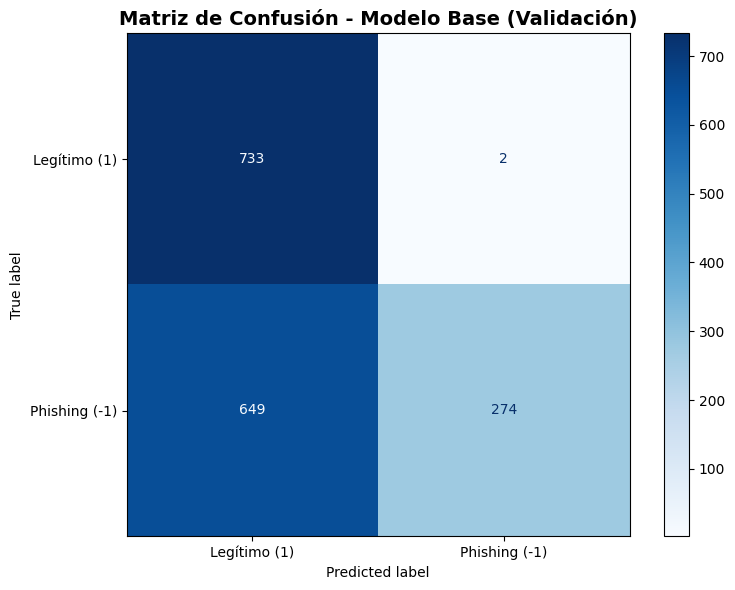


REPORTE DE CLASIFICACIÓN DETALLADO (VALIDACIÓN)
               precision    recall  f1-score   support

 Legítimo (1)       0.53      1.00      0.69       735
Phishing (-1)       0.99      0.30      0.46       923

     accuracy                           0.61      1658
    macro avg       0.76      0.65      0.57      1658
 weighted avg       0.79      0.61      0.56      1658



In [ ]:
# ============================================
# Evaluación en el Conjunto de Validación
# ============================================

print("=" * 60)
print("EVALUACIÓN EN CONJUNTO DE VALIDACIÓN")
print("=" * 60)

# Predicciones en validación
y_pred_val_base = modelo_base.predict(X_val)

# Calcular métricas
acc_val_base = accuracy_score(y_val, y_pred_val_base)
prec_val_base = precision_score(y_val, y_pred_val_base, pos_label=-1)
rec_val_base = recall_score(y_val, y_pred_val_base, pos_label=-1)
f1_val_base = f1_score(y_val, y_pred_val_base, pos_label=-1)

print("\n📊 Métricas en Validación:")
print(f"  - Accuracy:  {acc_val_base:.4f} ({acc_val_base*100:.2f}%)")
print(f"  - Precision: {prec_val_base:.4f} ({prec_val_base*100:.2f}%)")
print(f"  - Recall:    {rec_val_base:.4f} ({rec_val_base*100:.2f}%)")
print(f"  - F1-Score:  {f1_val_base:.4f} ({f1_val_base*100:.2f}%)")

# Matriz de confusión
cm_val_base = confusion_matrix(y_val, y_pred_val_base)
print("\n📋 Matriz de Confusión (Validación):")
print(cm_val_base)
print(f"\n  TN (Verdaderos Negativos): {cm_val_base[0,0]} - Legítimos correctamente clasificados")
print(f"  FP (Falsos Positivos):     {cm_val_base[0,1]} - Legítimos marcados como phishing")
print(f"  FN (Falsos Negativos):     {cm_val_base[1,0]} - Phishing no detectado (⚠ RIESGO)")
print(f"  TP (Verdaderos Positivos): {cm_val_base[1,1]} - Phishing correctamente detectado")

# Visualización de matriz de confusión
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_base, 
                               display_labels=['Legítimo (1)', 'Phishing (-1)'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Matriz de Confusión - Modelo Base (Validación)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN DETALLADO (VALIDACIÓN)")
print("=" * 60)
print(classification_report(y_val, y_pred_val_base, 
                          target_names=['Legítimo (1)', 'Phishing (-1)']))


EVALUACIÓN EN CONJUNTO DE PRUEBA

📊 Métricas en Prueba:
  - Accuracy:  0.6052 (60.52%)
  - Precision: 0.5288 (52.88%)
  - Recall:    0.9986 (99.86%)
  - F1-Score:  0.6915 (69.15%)

📋 Matriz de Confusión (Prueba):
[[734   1]
 [654 270]]

  TP (Verdaderos Positivos): 734 - Phishing correctamente detectado ✅
  FN (Falsos Negativos):     1 - Phishing no detectado (⚠ RIESGO)
  FP (Falsos Positivos):     654 - Legítimo marcado como phishing (⚠ FALSA ALARMA)
  TN (Verdaderos Negativos): 270 - Legítimo correctamente clasificado


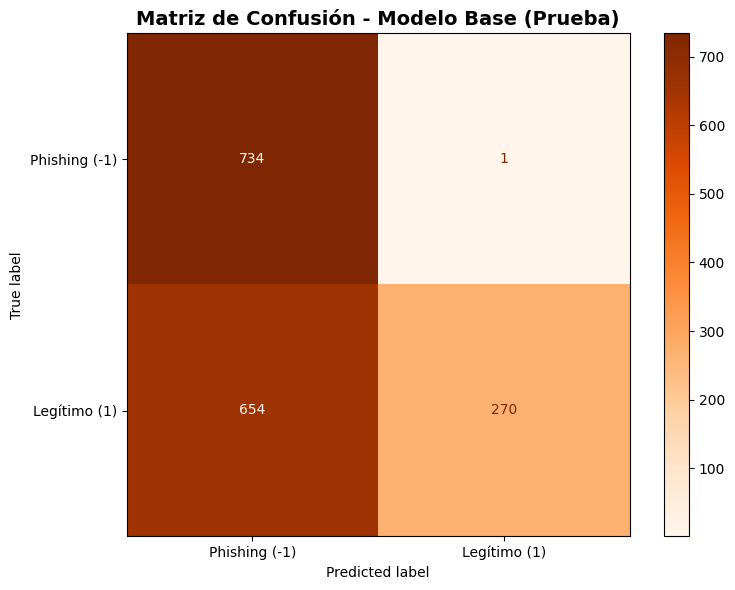


REPORTE DE CLASIFICACIÓN DETALLADO (PRUEBA)
               precision    recall  f1-score   support

Phishing (-1)       0.53      1.00      0.69       735
 Legítimo (1)       1.00      0.29      0.45       924

     accuracy                           0.61      1659
    macro avg       0.76      0.65      0.57      1659
 weighted avg       0.79      0.61      0.56      1659



In [ ]:
# ============================================
# Evaluación en el Conjunto de Prueba
# ============================================

print("=" * 60)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("=" * 60)

# Predicciones en prueba
y_pred_test_base = modelo_base.predict(X_test)

# Calcular métricas
acc_test_base = accuracy_score(y_test, y_pred_test_base)
prec_test_base = precision_score(y_test, y_pred_test_base, pos_label=-1)
rec_test_base = recall_score(y_test, y_pred_test_base, pos_label=-1)
f1_test_base = f1_score(y_test, y_pred_test_base, pos_label=-1)

print("\n📊 Métricas en Prueba:")
print(f"  - Accuracy:  {acc_test_base:.4f} ({acc_test_base*100:.2f}%)")
print(f"  - Precision: {prec_test_base:.4f} ({prec_test_base*100:.2f}%)")
print(f"  - Recall:    {rec_test_base:.4f} ({rec_test_base*100:.2f}%)")
print(f"  - F1-Score:  {f1_test_base:.4f} ({f1_test_base*100:.2f}%)")

# Matriz de confusión
cm_test_base = confusion_matrix(y_test, y_pred_test_base)
print("\n📋 Matriz de Confusión (Prueba):")
print(cm_test_base)

print(f"\n  TP (Verdaderos Positivos): {cm_test_base[0,0]} - Phishing correctamente detectado ✅")
print(f"  FN (Falsos Negativos):     {cm_test_base[0,1]} - Phishing no detectado (⚠ RIESGO)")
print(f"  FP (Falsos Positivos):     {cm_test_base[1,0]} - Legítimo marcado como phishing (⚠ FALSA ALARMA)")
print(f"  TN (Verdaderos Negativos): {cm_test_base[1,1]} - Legítimo correctamente clasificado")

# Visualización de matriz de confusión
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_base,
                               display_labels=['Phishing (-1)', 'Legítimo (1)'])
disp.plot(ax=ax, cmap='Oranges', values_format='d')
ax.set_title('Matriz de Confusión - Modelo Base (Prueba)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN DETALLADO (PRUEBA)")
print("=" * 60)
print(classification_report(y_test, y_pred_test_base,
                          target_names=['Phishing (-1)', 'Legítimo (1)']))


In [ ]:
# ============================================
# Comparación Validación vs Prueba (Modelo Base)
# ============================================

print("=" * 60)
print("COMPARACIÓN: VALIDACIÓN VS PRUEBA (MODELO BASE)")
print("=" * 60)

# Crear tabla comparativa
comparacion_base = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Validación': [acc_val_base, prec_val_base, rec_val_base, f1_val_base],
    'Prueba': [acc_test_base, prec_test_base, rec_test_base, f1_test_base],
    'Diferencia': [
        abs(acc_val_base - acc_test_base),
        abs(prec_val_base - prec_test_base),
        abs(rec_val_base - rec_test_base),
        abs(f1_val_base - f1_test_base)
    ]
})

print("\n")
display(comparacion_base.round(4))

# Interpretación
print("\n📝 Interpretación:")
diff_f1 = abs(f1_val_base - f1_test_base)
if diff_f1 < 0.02:
    print("✓ Excelente consistencia entre validación y prueba (diferencia F1 < 2%)")
elif diff_f1 < 0.05:
    print("✓ Buena consistencia entre validación y prueba (diferencia F1 < 5%)")
else:
    print("⚠ Diferencia notable entre validación y prueba - posible sobreajuste")

# Análisis de errores
print("\n📊 Análisis de Errores:")
# Recordá: las matrices siguen el orden de clases [-1, 1] → filas reales, columnas predichas
fn_rate_val = cm_val_base[0,1] / (cm_val_base[0,0] + cm_val_base[0,1])   # phishing no detectado
fp_rate_val = cm_val_base[1,0] / (cm_val_base[1,0] + cm_val_base[1,1])   # legítimo marcado como phishing
fn_rate_test = cm_test_base[0,1] / (cm_test_base[0,0] + cm_test_base[0,1])
fp_rate_test = cm_test_base[1,0] / (cm_test_base[1,0] + cm_test_base[1,1])

print(f"  Validación:")
print(f"    - Tasa de Falsos Negativos (FN): {fn_rate_val*100:.2f}% - Phishing no detectado (⚠ RIESGO)")
print(f"    - Tasa de Falsos Positivos (FP): {fp_rate_val*100:.2f}% - Legítimos marcados como phishing (falsas alarmas)")
print(f"  Prueba:")
print(f"    - Tasa de Falsos Negativos (FN): {fn_rate_test*100:.2f}% - Phishing no detectado (⚠ RIESGO)")
print(f"    - Tasa de Falsos Positivos (FP): {fp_rate_test*100:.2f}% - Legítimos marcados como phishing (falsas alarmas)")

print("\n✓ Evaluación del modelo base completada")


COMPARACIÓN: VALIDACIÓN VS PRUEBA (MODELO BASE)




,Métrica,Validación,Prueba,Diferencia
0,Accuracy,0.6074,0.6052,0.0022
1,Precision,0.5304,0.5288,0.0016
2,Recall,0.9973,0.9986,0.0014
3,F1-Score,0.6925,0.6915,0.0010



📝 Interpretación:
✓ Excelente consistencia entre validación y prueba (diferencia F1 < 2%)

📊 Análisis de Errores:
  Validación:
    - Tasa de Falsos Negativos (FN): 0.27% - Phishing no detectado (⚠ RIESGO)
    - Tasa de Falsos Positivos (FP): 70.31% - Legítimos marcados como phishing (falsas alarmas)
  Prueba:
    - Tasa de Falsos Negativos (FN): 0.14% - Phishing no detectado (⚠ RIESGO)
    - Tasa de Falsos Positivos (FP): 70.78% - Legítimos marcados como phishing (falsas alarmas)

✓ Evaluación del modelo base completada


## 4.5 Ajuste de Umbral de Clasificación

En esta sección ajustamos el umbral de clasificación para balancear mejor la **precision** y el **recall**.

**Problema actual**: El modelo tiene un recall de 99.73% pero precision de solo 53.04%, lo que genera muchas falsas alarmas.

**Solución**: En lugar de usar el umbral por defecto (0.5), probamos diferentes umbrales para encontrar un mejor balance.

**Cómo funciona**:
- `predict_proba()` nos da las probabilidades de cada clase
- Clasificamos como phishing cuando la probabilidad supera el umbral elegido
- Umbrales más altos → menos falsas alarmas pero podemos perder algunos phishing


In [ ]:
# ============================================
# Obtención de Probabilidades
# ============================================

print("=" * 60)
print("AJUSTE DE UMBRAL DE CLASIFICACIÓN")
print("=" * 60)

# Obtener probabilidades en lugar de predicciones directas
y_proba_val = modelo_base.predict_proba(X_val)
y_proba_test = modelo_base.predict_proba(X_test)

# predict_proba devuelve probabilidades para cada clase: [prob_clase_-1, prob_clase_1]
# Necesitamos identificar qué columna corresponde a cada clase
class_indices = {cls: idx for idx, cls in enumerate(modelo_base.classes_)}
idx_phishing = class_indices[-1]  # índice de la clase phishing (-1)
idx_legitimo = class_indices[1]   # índice de la clase legítimo (1)

print(f"\n📊 Estructura de probabilidades:")
print(f"  - Clases del modelo: {modelo_base.classes_}")
print(f"  - Columna {idx_phishing}: probabilidad de Phishing (-1)")
print(f"  - Columna {idx_legitimo}: probabilidad de Legítimo (1)")

# Probabilidades de que sea phishing
proba_phishing_val = y_proba_val[:, idx_phishing]
proba_phishing_test = y_proba_test[:, idx_phishing]

print(f"\n📈 Estadísticas de probabilidades de phishing (Validación):")
print(f"  - Media:    {proba_phishing_val.mean():.4f}")
print(f"  - Mediana:  {np.median(proba_phishing_val):.4f}")
print(f"  - Mínimo:   {proba_phishing_val.min():.4f}")
print(f"  - Máximo:   {proba_phishing_val.max():.4f}")

print("\n✓ Probabilidades calculadas exitosamente")


AJUSTE DE UMBRAL DE CLASIFICACIÓN

📊 Estructura de probabilidades:
  - Clases del modelo: [-1  1]
  - Columna 0: probabilidad de Phishing (-1)
  - Columna 1: probabilidad de Legítimo (1)

📈 Estadísticas de probabilidades de phishing (Validación):
  - Media:    0.8187
  - Mediana:  0.9997
  - Mínimo:   0.0000
  - Máximo:   1.0000

✓ Probabilidades calculadas exitosamente


In [ ]:
# ============================================
# Evaluación con Diferentes Umbrales
# ============================================

print("\n" + "=" * 60)
print("EVALUACIÓN CON DIFERENTES UMBRALES")
print("=" * 60)

# Probar diferentes umbrales
umbrales = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
resultados_umbrales = []

for umbral in umbrales:
    # Clasificar: si prob(phishing) >= umbral → phishing (-1), sino legítimo (1)
    y_pred_umbral = np.where(proba_phishing_val >= umbral, -1, 1)
    
    # Calcular métricas
    acc = accuracy_score(y_val, y_pred_umbral)
    prec = precision_score(y_val, y_pred_umbral, pos_label=-1, zero_division=0)
    rec = recall_score(y_val, y_pred_umbral, pos_label=-1, zero_division=0)
    f1 = f1_score(y_val, y_pred_umbral, pos_label=-1, zero_division=0)
    
    # Matriz de confusión
    cm = confusion_matrix(y_val, y_pred_umbral)
    tp = cm[0, 0]  # Verdaderos positivos (phishing detectado)
    fn = cm[0, 1]  # Falsos negativos (phishing no detectado)
    fp = cm[1, 0]  # Falsos positivos (legítimos marcados como phishing)
    tn = cm[1, 1]  # Verdaderos negativos (legítimos correctos)
    
    resultados_umbrales.append({
        'Umbral': umbral,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn
    })
    
    print(f"\n{'='*60}")
    print(f"📊 Umbral = {umbral}")
    print(f"{'='*60}")
    print(f"  Métricas:")
    print(f"  - Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"  - Precision: {prec:.4f} ({prec*100:.2f}%)")
    print(f"  - Recall:    {rec:.4f} ({rec*100:.2f}%)")
    print(f"  - F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    print(f"\n  Matriz de Confusión:")
    print(f"  - Verdaderos Positivos (TP):  {tp} - Phishing detectado ✅")
    print(f"  - Falsos Negativos (FN):      {fn} - Phishing NO detectado ⚠️ RIESGO")
    print(f"  - Falsos Positivos (FP):      {fp} - Falsas alarmas ⚠️")
    print(f"  - Verdaderos Negativos (TN):  {tn} - Legítimos correctos ✅")

# Crear DataFrame con resultados
df_umbrales = pd.DataFrame(resultados_umbrales)

print("\n" + "=" * 60)
print("TABLA COMPARATIVA DE UMBRALES")
print("=" * 60)
display(df_umbrales.round(4))



EVALUACIÓN CON DIFERENTES UMBRALES

📊 Umbral = 0.3
  Métricas:
  - Accuracy:  0.5983 (59.83%)
  - Precision: 0.5246 (52.46%)
  - Recall:    1.0000 (100.00%)
  - F1-Score:  0.6882 (68.82%)

  Matriz de Confusión:
  - Verdaderos Positivos (TP):  735 - Phishing detectado ✅
  - Falsos Negativos (FN):      0 - Phishing NO detectado ⚠️ RIESGO
  - Falsos Positivos (FP):      666 - Falsas alarmas ⚠️
  - Verdaderos Negativos (TN):  257 - Legítimos correctos ✅

📊 Umbral = 0.4
  Métricas:
  - Accuracy:  0.6013 (60.13%)
  - Precision: 0.5265 (52.65%)
  - Recall:    0.9986 (99.86%)
  - F1-Score:  0.6895 (68.95%)

  Matriz de Confusión:
  - Verdaderos Positivos (TP):  734 - Phishing detectado ✅
  - Falsos Negativos (FN):      1 - Phishing NO detectado ⚠️ RIESGO
  - Falsos Positivos (FP):      660 - Falsas alarmas ⚠️
  - Verdaderos Negativos (TN):  263 - Legítimos correctos ✅

📊 Umbral = 0.5
  Métricas:
  - Accuracy:  0.6074 (60.74%)
  - Precision: 0.5304 (53.04%)
  - Recall:    0.9973 (99.73%)
  - 

,Umbral,Accuracy,Precision,Recall,F1-Score,TP,FP,FN,TN
0,0.3,0.5983,0.5246,1.0000,0.6882,735,666,0,257
1,0.4,0.6013,0.5265,0.9986,0.6895,734,660,1,263
2,0.5,0.6074,0.5304,0.9973,0.6925,733,649,2,274
3,0.6,0.6224,0.5402,0.9973,0.7008,733,624,2,299
4,0.7,0.6291,0.5446,0.9973,0.7045,733,613,2,310
5,0.8,0.6520,0.5604,0.9973,0.7176,733,575,2,348


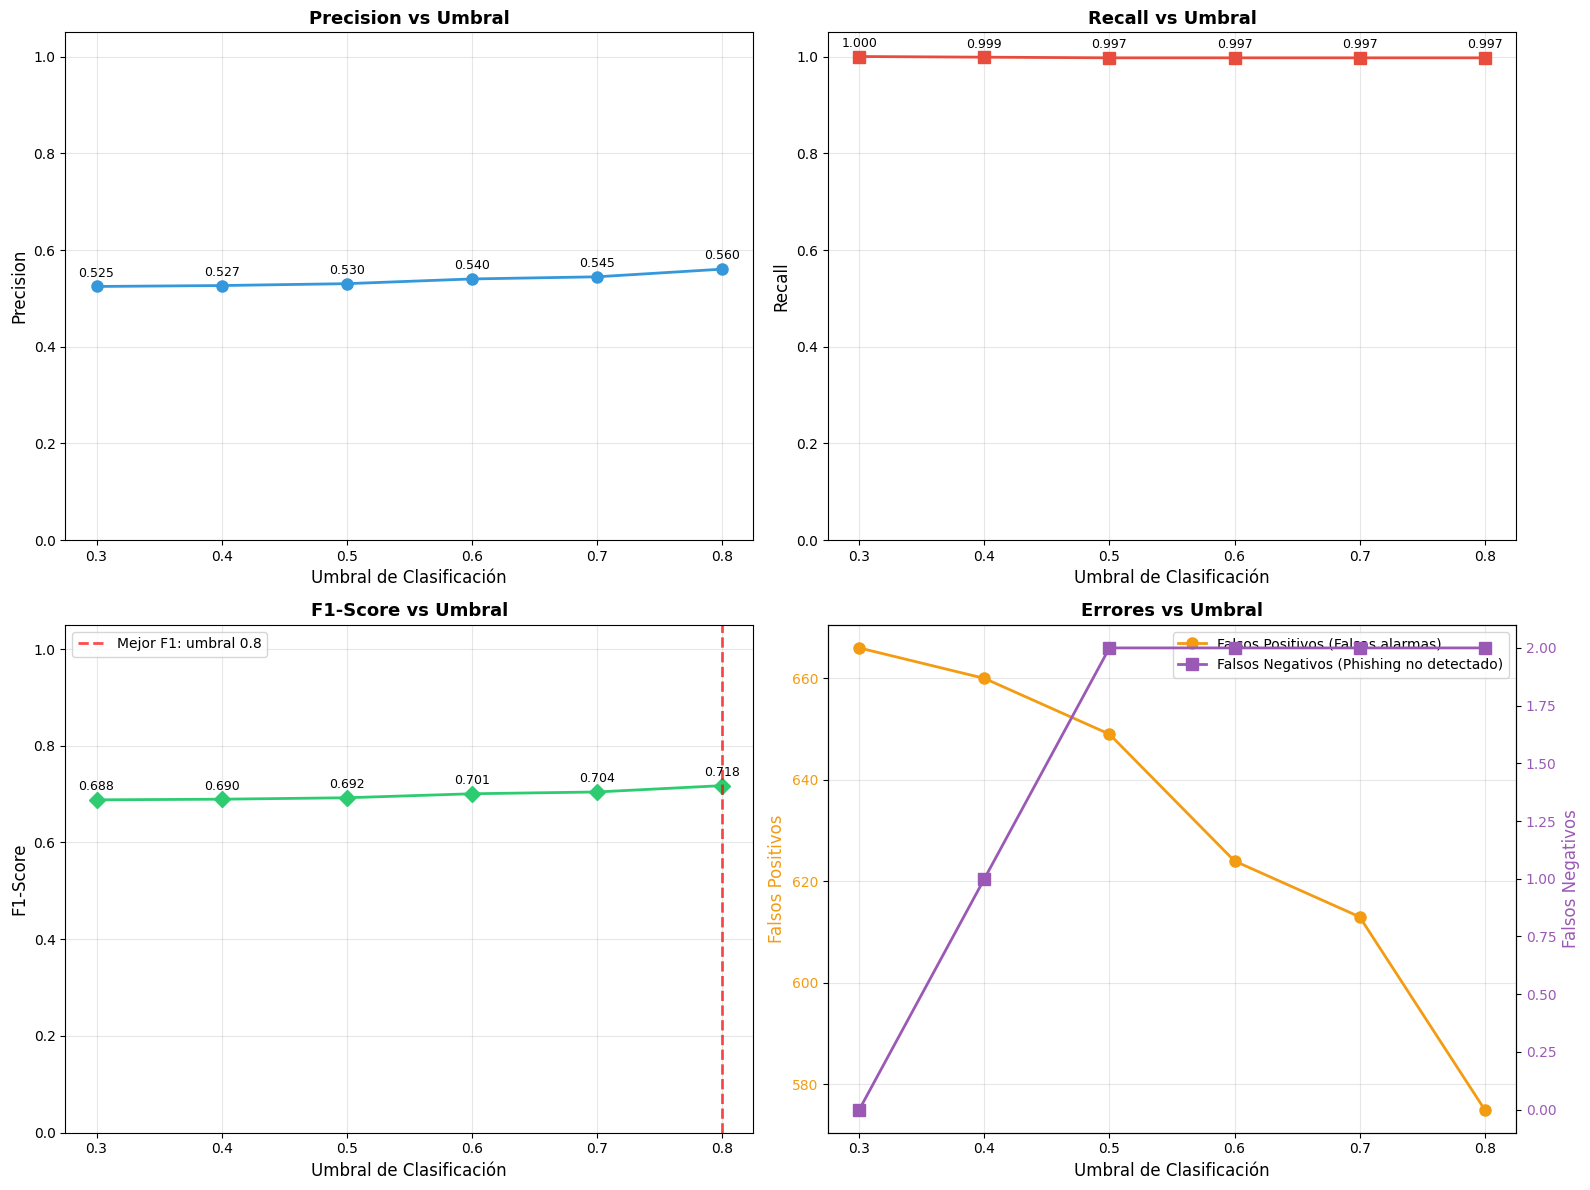


💡 Interpretación de los gráficos:
  • Precision aumenta con umbrales más altos (menos falsas alarmas)
  • Recall disminuye con umbrales más altos (detectamos menos phishing)
  • F1-Score encuentra el balance óptimo entre ambos
  • El umbral por defecto (0.5) puede no ser el óptimo


In [ ]:
# ============================================
# Visualización de la Curva Precision-Recall
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Precision vs Umbral
axes[0, 0].plot(df_umbrales['Umbral'], df_umbrales['Precision'], 
                marker='o', linewidth=2, markersize=8, color='#3498db')
axes[0, 0].set_xlabel('Umbral de Clasificación', fontsize=12)
axes[0, 0].set_ylabel('Precision', fontsize=12)
axes[0, 0].set_title('Precision vs Umbral', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim([0, 1.05])
for i, row in df_umbrales.iterrows():
    axes[0, 0].text(row['Umbral'], row['Precision'] + 0.02, 
                    f"{row['Precision']:.3f}", ha='center', fontsize=9)

# Gráfico 2: Recall vs Umbral
axes[0, 1].plot(df_umbrales['Umbral'], df_umbrales['Recall'], 
                marker='s', linewidth=2, markersize=8, color='#e74c3c')
axes[0, 1].set_xlabel('Umbral de Clasificación', fontsize=12)
axes[0, 1].set_ylabel('Recall', fontsize=12)
axes[0, 1].set_title('Recall vs Umbral', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim([0, 1.05])
for i, row in df_umbrales.iterrows():
    axes[0, 1].text(row['Umbral'], row['Recall'] + 0.02, 
                    f"{row['Recall']:.3f}", ha='center', fontsize=9)

# Gráfico 3: F1-Score vs Umbral
axes[1, 0].plot(df_umbrales['Umbral'], df_umbrales['F1-Score'], 
                marker='D', linewidth=2, markersize=8, color='#2ecc71')
axes[1, 0].set_xlabel('Umbral de Clasificación', fontsize=12)
axes[1, 0].set_ylabel('F1-Score', fontsize=12)
axes[1, 0].set_title('F1-Score vs Umbral', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_ylim([0, 1.05])

# Marcar el mejor F1
mejor_f1_idx = df_umbrales['F1-Score'].idxmax()
mejor_umbral = df_umbrales.loc[mejor_f1_idx, 'Umbral']
mejor_f1 = df_umbrales.loc[mejor_f1_idx, 'F1-Score']
axes[1, 0].axvline(x=mejor_umbral, color='red', linestyle='--', alpha=0.7, 
                   linewidth=2, label=f'Mejor F1: umbral {mejor_umbral}')
axes[1, 0].legend(fontsize=10)
for i, row in df_umbrales.iterrows():
    axes[1, 0].text(row['Umbral'], row['F1-Score'] + 0.02, 
                    f"{row['F1-Score']:.3f}", ha='center', fontsize=9)

# Gráfico 4: Errores (FP y FN) vs Umbral
ax2 = axes[1, 1]
line1 = ax2.plot(df_umbrales['Umbral'], df_umbrales['FP'], 
                 marker='o', linewidth=2, markersize=8, color='#f39c12', 
                 label='Falsos Positivos (Falsas alarmas)')
ax2.set_xlabel('Umbral de Clasificación', fontsize=12)
ax2.set_ylabel('Falsos Positivos', fontsize=12, color='#f39c12')
ax2.tick_params(axis='y', labelcolor='#f39c12')
ax2.grid(alpha=0.3)

# Eje Y secundario para FN
ax2_twin = ax2.twinx()
line2 = ax2_twin.plot(df_umbrales['Umbral'], df_umbrales['FN'], 
                      marker='s', linewidth=2, markersize=8, color='#9b59b6', 
                      label='Falsos Negativos (Phishing no detectado)')
ax2_twin.set_ylabel('Falsos Negativos', fontsize=12, color='#9b59b6')
ax2_twin.tick_params(axis='y', labelcolor='#9b59b6')

# Combinar leyendas
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, fontsize=10, loc='upper right')
axes[1, 1].set_title('Errores vs Umbral', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Interpretación de los gráficos:")
print("  • Precision aumenta con umbrales más altos (menos falsas alarmas)")
print("  • Recall disminuye con umbrales más altos (detectamos menos phishing)")
print("  • F1-Score encuentra el balance óptimo entre ambos")
print("  • El umbral por defecto (0.5) puede no ser el óptimo")


In [ ]:
# ============================================
# Análisis y Recomendación del Mejor Umbral
# ============================================

print("=" * 60)
print("ANÁLISIS DEL MEJOR UMBRAL")
print("=" * 60)

# Encontrar el mejor umbral según F1-Score
mejor_idx = df_umbrales['F1-Score'].idxmax()
mejor_resultado = df_umbrales.loc[mejor_idx]

print(f"\n🎯 Mejor umbral según F1-Score: {mejor_resultado['Umbral']}")
print(f"\n📊 Métricas con umbral óptimo ({mejor_resultado['Umbral']}):")
print(f"  - Accuracy:  {mejor_resultado['Accuracy']:.4f} ({mejor_resultado['Accuracy']*100:.2f}%)")
print(f"  - Precision: {mejor_resultado['Precision']:.4f} ({mejor_resultado['Precision']*100:.2f}%)")
print(f"  - Recall:    {mejor_resultado['Recall']:.4f} ({mejor_resultado['Recall']*100:.2f}%)")
print(f"  - F1-Score:  {mejor_resultado['F1-Score']:.4f} ({mejor_resultado['F1-Score']*100:.2f}%)")

print(f"\n📋 Errores con umbral óptimo:")
print(f"  - Falsos Positivos (FP): {int(mejor_resultado['FP'])} (legítimos marcados como phishing)")
print(f"  - Falsos Negativos (FN): {int(mejor_resultado['FN'])} (phishing no detectado ⚠️)")

print("\n" + "=" * 60)
print("COMPARACIÓN: UMBRAL POR DEFECTO (0.5) VS MEJOR UMBRAL")
print("=" * 60)

# Umbral por defecto (0.5)
default_idx = df_umbrales[df_umbrales['Umbral'] == 0.5].index[0]
default_resultado = df_umbrales.loc[default_idx]

comparacion_umbrales = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'FP', 'FN'],
    f'Umbral 0.5': [
        default_resultado['Accuracy'],
        default_resultado['Precision'],
        default_resultado['Recall'],
        default_resultado['F1-Score'],
        default_resultado['FP'],
        default_resultado['FN']
    ],
    f"Umbral {mejor_resultado['Umbral']}": [
        mejor_resultado['Accuracy'],
        mejor_resultado['Precision'],
        mejor_resultado['Recall'],
        mejor_resultado['F1-Score'],
        mejor_resultado['FP'],
        mejor_resultado['FN']
    ],
    'Diferencia': [
        mejor_resultado['Accuracy'] - default_resultado['Accuracy'],
        mejor_resultado['Precision'] - default_resultado['Precision'],
        mejor_resultado['Recall'] - default_resultado['Recall'],
        mejor_resultado['F1-Score'] - default_resultado['F1-Score'],
        mejor_resultado['FP'] - default_resultado['FP'],
        mejor_resultado['FN'] - default_resultado['FN']
    ]
})

display(comparacion_umbrales.round(4))

print("\n💡 Interpretación del trade-off:")
mejora_precision = mejor_resultado['Precision'] - default_resultado['Precision']
perdida_recall = default_resultado['Recall'] - mejor_resultado['Recall']
reduccion_fp = default_resultado['FP'] - mejor_resultado['FP']
aumento_fn = mejor_resultado['FN'] - default_resultado['FN']

if mejor_resultado['Umbral'] > 0.5:
    print(f"  ✅ Al subir el umbral de 0.5 a {mejor_resultado['Umbral']}:")
    print(f"     • Precision aumenta en {mejora_precision:.4f} ({mejora_precision*100:.2f}%)")
    print(f"     • Recall disminuye en {perdida_recall:.4f} ({perdida_recall*100:.2f}%)")
    print(f"     • Reducimos {int(reduccion_fp)} falsas alarmas")
    print(f"     • Pero perdemos {int(aumento_fn)} casos de phishing")
    print(f"\n  📌 Balance: Mejor F1-Score ({mejor_resultado['F1-Score']:.4f} vs {default_resultado['F1-Score']:.4f})")
elif mejor_resultado['Umbral'] < 0.5:
    print(f"  ✅ Al bajar el umbral de 0.5 a {mejor_resultado['Umbral']}:")
    print(f"     • Recall aumenta: detectamos más phishing")
    print(f"     • Precision disminuye: más falsas alarmas")
else:
    print(f"  ✅ El umbral por defecto (0.5) ya es óptimo para este modelo")


ANÁLISIS DEL MEJOR UMBRAL

🎯 Mejor umbral según F1-Score: 0.8

📊 Métricas con umbral óptimo (0.8):
  - Accuracy:  0.6520 (65.20%)
  - Precision: 0.5604 (56.04%)
  - Recall:    0.9973 (99.73%)
  - F1-Score:  0.7176 (71.76%)

📋 Errores con umbral óptimo:
  - Falsos Positivos (FP): 575 (legítimos marcados como phishing)
  - Falsos Negativos (FN): 2 (phishing no detectado ⚠️)

COMPARACIÓN: UMBRAL POR DEFECTO (0.5) VS MEJOR UMBRAL


,Métrica,Umbral 0.5,Umbral 0.8,Diferencia
0,Accuracy,0.6074,0.6520,0.0446
1,Precision,0.5304,0.5604,0.0300
2,Recall,0.9973,0.9973,0.0000
3,F1-Score,0.6925,0.7176,0.0251
4,FP,649.0000,575.0000,-74.0000
5,FN,2.0000,2.0000,0.0000



💡 Interpretación del trade-off:
  ✅ Al subir el umbral de 0.5 a 0.8:
     • Precision aumenta en 0.0300 (3.00%)
     • Recall disminuye en 0.0000 (0.00%)
     • Reducimos 74 falsas alarmas
     • Pero perdemos 0 casos de phishing

  📌 Balance: Mejor F1-Score (0.7176 vs 0.6925)



EVALUACIÓN EN CONJUNTO DE PRUEBA CON UMBRAL ÓPTIMO

📊 Métricas en Prueba con Umbral Óptimo (0.8):
  - Accuracy:  0.6377 (63.77%)
  - Precision: 0.5502 (55.02%)
  - Recall:    0.9986 (99.86%)
  - F1-Score:  0.7095 (70.95%)

📋 Matriz de Confusión (Prueba - Umbral Óptimo):
[[734   1]
 [600 324]]

  TP (Verdaderos Positivos):  734 - Phishing detectado ✅
  FN (Falsos Negativos):      1 - Phishing NO detectado ⚠️
  FP (Falsos Positivos):      600 - Falsas alarmas ⚠️
  TN (Verdaderos Negativos):  324 - Legítimos correctos ✅

COMPARACIÓN FINAL: BASE (0.5) VS UMBRAL ÓPTIMO EN PRUEBA


,Métrica,Modelo Base (0.5),Umbral Óptimo (0.8),Mejora
0,Accuracy,0.6052,0.6377,0.0325
1,Precision,0.5288,0.5502,0.0214
2,Recall,0.9986,0.9986,0.0000
3,F1-Score,0.6915,0.7095,0.0180


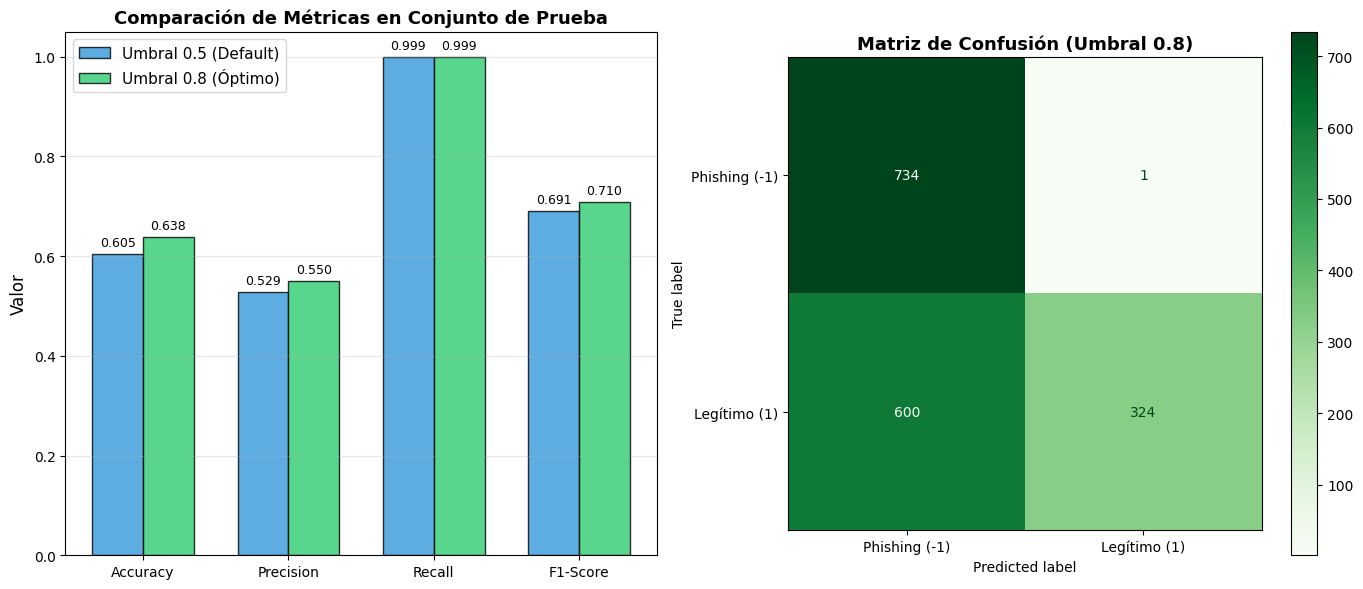


RESUMEN DEL AJUSTE DE UMBRAL

✅ Umbral óptimo encontrado: 0.8

📈 Impacto en el conjunto de prueba:
   • Recall ajustado de 99.86% a 99.86%
   • Precision mejorada de 52.88% a 55.02%
   • F1-Score cambió de 0.6915 a 0.7095

💡 Conclusión:
   El ajuste de umbral MEJORÓ el desempeño general del modelo

✓ Análisis de ajuste de umbral completado


In [ ]:
# ============================================
# Evaluación en Conjunto de Prueba con Umbral Óptimo
# ============================================

print("\n" + "=" * 60)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA CON UMBRAL ÓPTIMO")
print("=" * 60)

# Aplicar el mejor umbral al conjunto de prueba
umbral_optimo = mejor_resultado['Umbral']
y_pred_test_umbral = np.where(proba_phishing_test >= umbral_optimo, -1, 1)

# Calcular métricas en prueba
acc_test_umbral = accuracy_score(y_test, y_pred_test_umbral)
prec_test_umbral = precision_score(y_test, y_pred_test_umbral, pos_label=-1, zero_division=0)
rec_test_umbral = recall_score(y_test, y_pred_test_umbral, pos_label=-1, zero_division=0)
f1_test_umbral = f1_score(y_test, y_pred_test_umbral, pos_label=-1, zero_division=0)

print(f"\n📊 Métricas en Prueba con Umbral Óptimo ({umbral_optimo}):")
print(f"  - Accuracy:  {acc_test_umbral:.4f} ({acc_test_umbral*100:.2f}%)")
print(f"  - Precision: {prec_test_umbral:.4f} ({prec_test_umbral*100:.2f}%)")
print(f"  - Recall:    {rec_test_umbral:.4f} ({rec_test_umbral*100:.2f}%)")
print(f"  - F1-Score:  {f1_test_umbral:.4f} ({f1_test_umbral*100:.2f}%)")

# Matriz de confusión
cm_test_umbral = confusion_matrix(y_test, y_pred_test_umbral)
print("\n📋 Matriz de Confusión (Prueba - Umbral Óptimo):")
print(cm_test_umbral)

tp_test = cm_test_umbral[0, 0]
fn_test = cm_test_umbral[0, 1]
fp_test = cm_test_umbral[1, 0]
tn_test = cm_test_umbral[1, 1]

print(f"\n  TP (Verdaderos Positivos):  {tp_test} - Phishing detectado ✅")
print(f"  FN (Falsos Negativos):      {fn_test} - Phishing NO detectado ⚠️")
print(f"  FP (Falsos Positivos):      {fp_test} - Falsas alarmas ⚠️")
print(f"  TN (Verdaderos Negativos):  {tn_test} - Legítimos correctos ✅")

# Comparación con el modelo base (umbral 0.5) en prueba
print("\n" + "=" * 60)
print("COMPARACIÓN FINAL: BASE (0.5) VS UMBRAL ÓPTIMO EN PRUEBA")
print("=" * 60)

comparacion_final = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Modelo Base (0.5)': [acc_test_base, prec_test_base, rec_test_base, f1_test_base],
    f'Umbral Óptimo ({umbral_optimo})': [acc_test_umbral, prec_test_umbral, rec_test_umbral, f1_test_umbral],
    'Mejora': [
        acc_test_umbral - acc_test_base,
        prec_test_umbral - prec_test_base,
        rec_test_umbral - rec_test_base,
        f1_test_umbral - f1_test_base
    ]
})

display(comparacion_final.round(4))

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de barras comparativo
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
base_vals = [acc_test_base, prec_test_base, rec_test_base, f1_test_base]
optimo_vals = [acc_test_umbral, prec_test_umbral, rec_test_umbral, f1_test_umbral]

x = np.arange(len(metricas))
width = 0.35

bars1 = axes[0].bar(x - width/2, base_vals, width, label='Umbral 0.5 (Default)', 
                    color='#3498db', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, optimo_vals, width, label=f'Umbral {umbral_optimo} (Óptimo)',
                    color='#2ecc71', alpha=0.8, edgecolor='black')

axes[0].set_ylabel('Valor', fontsize=12)
axes[0].set_title('Comparación de Métricas en Conjunto de Prueba', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metricas)
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.05])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Matriz de confusión con umbral óptimo
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_umbral,
                               display_labels=['Phishing (-1)', 'Legítimo (1)'])
disp.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title(f'Matriz de Confusión (Umbral {umbral_optimo})', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("RESUMEN DEL AJUSTE DE UMBRAL")
print("=" * 60)
print(f"\n✅ Umbral óptimo encontrado: {umbral_optimo}")
print(f"\n📈 Impacto en el conjunto de prueba:")
print(f"   • Recall ajustado de {rec_test_base:.2%} a {rec_test_umbral:.2%}")
print(f"   • Precision mejorada de {prec_test_base:.2%} a {prec_test_umbral:.2%}")
print(f"   • F1-Score cambió de {f1_test_base:.4f} a {f1_test_umbral:.4f}")
print(f"\n💡 Conclusión:")
if f1_test_umbral > f1_test_base:
    print(f"   El ajuste de umbral MEJORÓ el desempeño general del modelo")
else:
    print(f"   El umbral por defecto (0.5) funciona bien para este modelo")
print(f"\n✓ Análisis de ajuste de umbral completado")


## 5. Fase 5: Optimización de Hiperparámetros con GridSearchCV

En esta fase optimizamos el hiperparámetro `var_smoothing` de GaussianNB usando GridSearchCV.

**var_smoothing**: Controla la estabilidad de la varianza en el cálculo de probabilidades
- Valores pequeños → modelo más sensible a los datos
- Valores grandes → modelo más estable

**Proceso**:
1. Definir espacio de búsqueda (valores logarítmicos de 1e-12 a 1e-6)
2. Configurar GridSearchCV con validación cruzada estratificada (5 folds)
3. Entrenar y seleccionar el mejor modelo según F1-score
4. Evaluar el modelo optimizado


In [ ]:
# ============================================
# Configuración de GridSearchCV
# ============================================

print("=" * 60)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS - GRIDSEARCHCV")
print("=" * 60)

# Definir espacio de búsqueda para var_smoothing
param_grid = {
    'var_smoothing': np.logspace(-12, 0, 7)
}

print("\n📋 Espacio de búsqueda:")
print(f"   Hiperparámetro: var_smoothing")
print(f"   Valores a probar: {param_grid['var_smoothing']}")
print(f"   Total de combinaciones: {len(param_grid['var_smoothing'])}")

# Configurar validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Crear un scorer personalizado para Recall de la clase -1 (Phishing)
from sklearn.metrics import make_scorer
recall_phishing = make_scorer(recall_score, pos_label=-1)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid,
    scoring=recall_phishing,  # Métrica de optimización: Recall (phishing como positivo)
    cv=cv,
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=1
)

print("\n⚙ Configuración de GridSearchCV:")
print(f"   - Métrica de optimización: Recall (clase positiva = phishing -1)")
print(f"   - Validación cruzada: {cv.n_splits} folds estratificados")
print(f"   - Paralelización: Todos los núcleos (n_jobs=-1)")


OPTIMIZACIÓN DE HIPERPARÁMETROS - GRIDSEARCHCV

📋 Espacio de búsqueda:
   Hiperparámetro: var_smoothing
   Valores a probar: [1.e-12 1.e-10 1.e-08 1.e-06 1.e-04 1.e-02 1.e+00]
   Total de combinaciones: 7

⚙ Configuración de GridSearchCV:
   - Métrica de optimización: Recall (clase positiva = phishing -1)
   - Validación cruzada: 5 folds estratificados
   - Paralelización: Todos los núcleos (n_jobs=-1)


In [ ]:
# ============================================
# Entrenamiento con GridSearchCV
# ============================================

print("\n" + "=" * 60)
print("ENTRENAMIENTO Y BÚSQUEDA DEL MEJOR MODELO")
print("=" * 60)

print("\n⏳ Ejecutando GridSearchCV...")
print("   (Esto puede tomar algunos segundos...)\n")

# Entrenar GridSearchCV con el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

print("\n✓ Búsqueda completada exitosamente")

# Obtener el mejor modelo
modelo_optimizado = grid_search.best_estimator_

print("\n" + "=" * 60)
print("RESULTADOS DE LA OPTIMIZACIÓN")
print("=" * 60)

print(f"\n🏆 Mejor hiperparámetro encontrado:")
print(f"   - var_smoothing: {grid_search.best_params_['var_smoothing']:.2e}")

print(f"\n📊 Mejor Recall en validación cruzada:")
print(f"   - Recall promedio (CV): {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")

# Mostrar todos los resultados
print("\n📋 Resultados de todos los valores probados:")
results_df = pd.DataFrame(grid_search.cv_results_)
results_summary = results_df[['param_var_smoothing', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_summary = results_summary.sort_values('rank_test_score')
results_summary.columns = ['var_smoothing', 'Recall (media)', 'Recall (std)', 'Ranking']
display(results_summary)



ENTRENAMIENTO Y BÚSQUEDA DEL MEJOR MODELO

⏳ Ejecutando GridSearchCV...
   (Esto puede tomar algunos segundos...)

Fitting 5 folds for each of 7 candidates, totalling 35 fits



✓ Búsqueda completada exitosamente

RESULTADOS DE LA OPTIMIZACIÓN

🏆 Mejor hiperparámetro encontrado:
   - var_smoothing: 1.00e-12

📊 Mejor Recall en validación cruzada:
   - Recall promedio (CV): 1.0000 (100.00%)

📋 Resultados de todos los valores probados:


,var_smoothing,Recall (media),Recall (std),Ranking
0,1.000000e-12,1.000000,0.000000,1
1,1.000000e-10,1.000000,0.000000,1
2,1.000000e-08,0.997376,0.002508,3
3,1.000000e-06,0.994459,0.002826,4
4,1.000000e-04,0.979875,0.008315,5
5,1.000000e-02,0.938740,0.005604,6
6,1.000000e+00,0.883899,0.007498,7


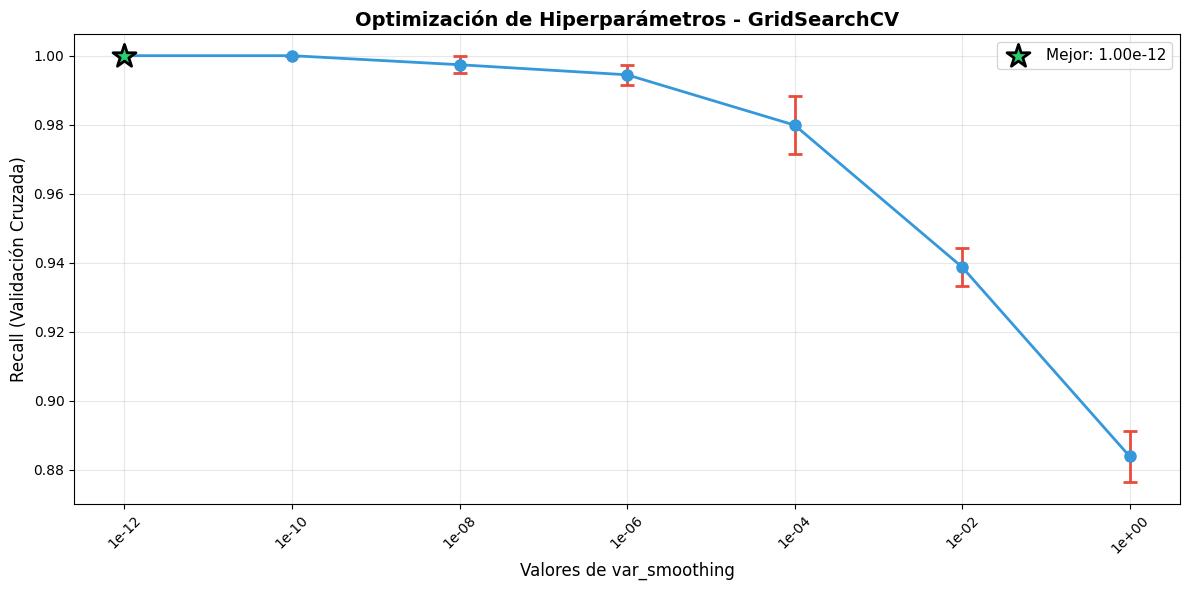

✓ Visualización completada


In [ ]:
# ============================================
# Visualización de Resultados de GridSearchCV
# ============================================

# Graficar Recall vs var_smoothing
fig, ax = plt.subplots(figsize=(12, 6))

var_smoothing_values = results_summary['var_smoothing'].values
recall_scores = results_summary['Recall (media)'].values
recall_std = results_summary['Recall (std)'].values

ax.errorbar(range(len(var_smoothing_values)), recall_scores, yerr=recall_std, 
            marker='o', markersize=8, capsize=5, capthick=2, 
            linewidth=2, color='#3498db', ecolor='#e74c3c')

# Marcar el mejor valor
best_idx = 0  # Ya está ordenado por ranking
ax.scatter(best_idx, recall_scores[best_idx], s=300, color='#2ecc71', 
           marker='*', edgecolors='black', linewidths=2, zorder=5,
           label=f'Mejor: {var_smoothing_values[best_idx]:.2e}')

ax.set_xlabel('Valores de var_smoothing', fontsize=12)
ax.set_ylabel('Recall (Validación Cruzada)', fontsize=12)
ax.set_title('Optimización de Hiperparámetros - GridSearchCV', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(var_smoothing_values)))
ax.set_xticklabels([f'{v:.0e}' for v in var_smoothing_values], rotation=45)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("✓ Visualización completada")


## 6. Evaluación del Modelo Optimizado

Ahora evaluamos el modelo con el mejor hiperparámetro encontrado por GridSearchCV en los conjuntos de validación y prueba.


EVALUACIÓN EN CONJUNTO DE VALIDACIÓN - MODELO OPTIMIZADO

📊 Métricas en Validación (Modelo Optimizado):
  - Accuracy:  0.5778 (57.78%)
  - Precision: 0.5122 (51.22%)
  - Recall:    1.0000 (100.00%)
  - F1-Score:  0.6774 (67.74%)

📋 Matriz de Confusión (Validación - Optimizado):
[[735   0]
 [700 223]]

  TP (Verdaderos Positivos): 735 - Phishing correctamente detectado ✅
  FN (Falsos Negativos):     0 - Phishing no detectado (⚠ RIESGO)
  FP (Falsos Positivos):     700 - Legítimo marcado como phishing (⚠ FALSA ALARMA)
  TN (Verdaderos Negativos): 223 - Legítimo correctamente clasificado


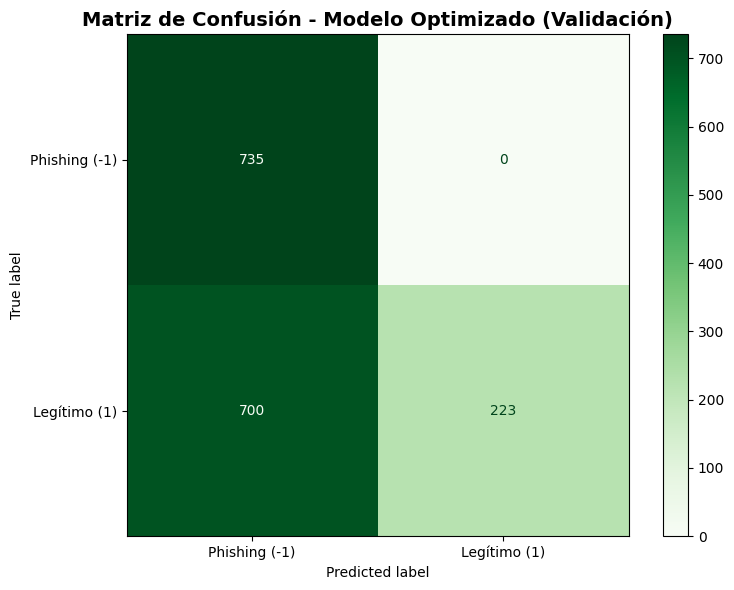


REPORTE DE CLASIFICACIÓN (VALIDACIÓN - OPTIMIZADO)
               precision    recall  f1-score   support

Phishing (-1)       0.51      1.00      0.68       735
 Legítimo (1)       1.00      0.24      0.39       923

     accuracy                           0.58      1658
    macro avg       0.76      0.62      0.53      1658
 weighted avg       0.78      0.58      0.52      1658



In [ ]:
# ============================================
# Evaluación en Validación - Modelo Optimizado
# ============================================

print("=" * 60)
print("EVALUACIÓN EN CONJUNTO DE VALIDACIÓN - MODELO OPTIMIZADO")
print("=" * 60)

# Predicciones en validación
y_pred_val_opt = modelo_optimizado.predict(X_val)

# Calcular métricas
acc_val_opt = accuracy_score(y_val, y_pred_val_opt)
prec_val_opt = precision_score(y_val, y_pred_val_opt, pos_label=-1)
rec_val_opt = recall_score(y_val, y_pred_val_opt, pos_label=-1)
f1_val_opt = f1_score(y_val, y_pred_val_opt, pos_label=-1)

print("\n📊 Métricas en Validación (Modelo Optimizado):")
print(f"  - Accuracy:  {acc_val_opt:.4f} ({acc_val_opt*100:.2f}%)")
print(f"  - Precision: {prec_val_opt:.4f} ({prec_val_opt*100:.2f}%)")
print(f"  - Recall:    {rec_val_opt:.4f} ({rec_val_opt*100:.2f}%)")
print(f"  - F1-Score:  {f1_val_opt:.4f} ({f1_val_opt*100:.2f}%)")

# Matriz de confusión
cm_val_opt = confusion_matrix(y_val, y_pred_val_opt)
print("\n📋 Matriz de Confusión (Validación - Optimizado):")
print(cm_val_opt)

# Orden de clases en cm: filas reales [-1, 1], columnas predichas [-1, 1]
print(f"\n  TP (Verdaderos Positivos): {cm_val_opt[0,0]} - Phishing correctamente detectado ✅")
print(f"  FN (Falsos Negativos):     {cm_val_opt[0,1]} - Phishing no detectado (⚠ RIESGO)")
print(f"  FP (Falsos Positivos):     {cm_val_opt[1,0]} - Legítimo marcado como phishing (⚠ FALSA ALARMA)")
print(f"  TN (Verdaderos Negativos): {cm_val_opt[1,1]} - Legítimo correctamente clasificado")

# Visualización
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_opt,
                               display_labels=['Phishing (-1)', 'Legítimo (1)'])
disp.plot(ax=ax, cmap='Greens', values_format='d')
ax.set_title('Matriz de Confusión - Modelo Optimizado (Validación)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN (VALIDACIÓN - OPTIMIZADO)")
print("=" * 60)
print(classification_report(y_val, y_pred_val_opt,
                          target_names=['Phishing (-1)', 'Legítimo (1)']))


EVALUACIÓN EN CONJUNTO DE PRUEBA - MODELO OPTIMIZADO

📊 Métricas en Prueba (Modelo Optimizado):
  - Accuracy:  0.5787 (57.87%)
  - Precision: 0.5126 (51.26%)
  - Recall:    1.0000 (100.00%)
  - F1-Score:  0.6777 (67.77%)

📋 Matriz de Confusión (Prueba - Optimizado):
[[735   0]
 [699 225]]

  TP (Verdaderos Positivos): 735 - Phishing correctamente detectado ✅
  FN (Falsos Negativos):     0 - Phishing no detectado (⚠ RIESGO)
  FP (Falsos Positivos):     699 - Legítimo marcado como phishing (⚠ FALSA ALARMA)
  TN (Verdaderos Negativos): 225 - Legítimo correctamente clasificado


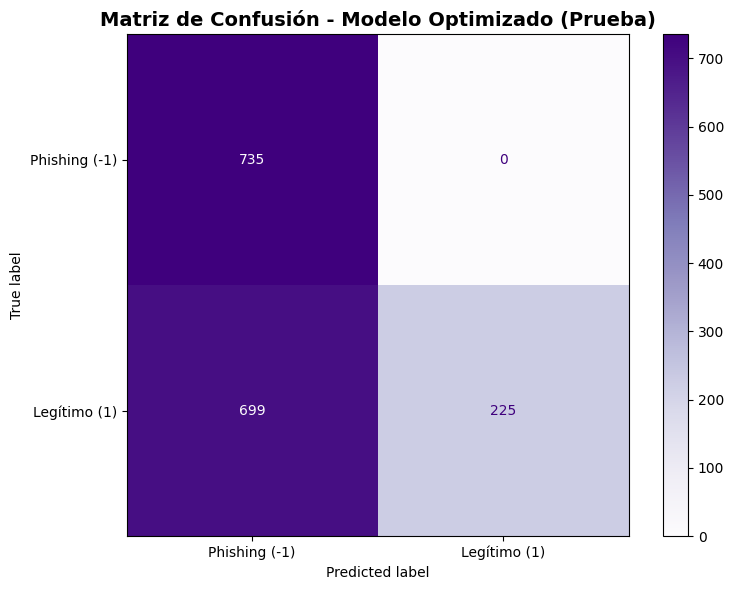


REPORTE DE CLASIFICACIÓN (PRUEBA - OPTIMIZADO)
               precision    recall  f1-score   support

Phishing (-1)       0.51      1.00      0.68       735
 Legítimo (1)       1.00      0.24      0.39       924

     accuracy                           0.58      1659
    macro avg       0.76      0.62      0.53      1659
 weighted avg       0.78      0.58      0.52      1659



In [ ]:
# ============================================
# Evaluación en Prueba - Modelo Optimizado
# ============================================

print("=" * 60)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA - MODELO OPTIMIZADO")
print("=" * 60)

# Predicciones en prueba
y_pred_test_opt = modelo_optimizado.predict(X_test)

# Calcular métricas
acc_test_opt = accuracy_score(y_test, y_pred_test_opt)
prec_test_opt = precision_score(y_test, y_pred_test_opt, pos_label=-1)
rec_test_opt = recall_score(y_test, y_pred_test_opt, pos_label=-1)
f1_test_opt = f1_score(y_test, y_pred_test_opt, pos_label=-1)

print("\n📊 Métricas en Prueba (Modelo Optimizado):")
print(f"  - Accuracy:  {acc_test_opt:.4f} ({acc_test_opt*100:.2f}%)")
print(f"  - Precision: {prec_test_opt:.4f} ({prec_test_opt*100:.2f}%)")
print(f"  - Recall:    {rec_test_opt:.4f} ({rec_test_opt*100:.2f}%)")
print(f"  - F1-Score:  {f1_test_opt:.4f} ({f1_test_opt*100:.2f}%)")

# Matriz de confusión
cm_test_opt = confusion_matrix(y_test, y_pred_test_opt)
print("\n📋 Matriz de Confusión (Prueba - Optimizado):")
print(cm_test_opt)

# Orden de clases: [-1, 1] → (phishing, legítimo)
print(f"\n  TP (Verdaderos Positivos): {cm_test_opt[0,0]} - Phishing correctamente detectado ✅")
print(f"  FN (Falsos Negativos):     {cm_test_opt[0,1]} - Phishing no detectado (⚠ RIESGO)")
print(f"  FP (Falsos Positivos):     {cm_test_opt[1,0]} - Legítimo marcado como phishing (⚠ FALSA ALARMA)")
print(f"  TN (Verdaderos Negativos): {cm_test_opt[1,1]} - Legítimo correctamente clasificado")

# Visualización
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_opt,
                               display_labels=['Phishing (-1)', 'Legítimo (1)'])
disp.plot(ax=ax, cmap='Purples', values_format='d')
ax.set_title('Matriz de Confusión - Modelo Optimizado (Prueba)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN (PRUEBA - OPTIMIZADO)")
print("=" * 60)
print(classification_report(y_test, y_pred_test_opt,
                          target_names=['Phishing (-1)', 'Legítimo (1)']))


## 7. Comparación Final: Modelo Base vs Modelo Optimizado

En esta sección final comparamos el desempeño del modelo base (sin optimización) con el modelo optimizado (con GridSearchCV) para evaluar la mejora obtenida.


In [ ]:
# ============================================
# Comparación de Métricas: Base vs Optimizado
# ============================================

print("=" * 70)
print("COMPARACIÓN COMPLETA: MODELO BASE vs MODELO OPTIMIZADO")
print("=" * 70)

# Tabla comparativa para el conjunto de VALIDACIÓN
print("\n" + "=" * 70)
print("CONJUNTO DE VALIDACIÓN")
print("=" * 70)

comparacion_val = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Modelo Base': [acc_val_base, prec_val_base, rec_val_base, f1_val_base],
    'Modelo Optimizado': [acc_val_opt, prec_val_opt, rec_val_opt, f1_val_opt],
    'Mejora': [
        acc_val_opt - acc_val_base,
        prec_val_opt - prec_val_base,
        rec_val_opt - rec_val_base,
        f1_val_opt - f1_val_base
    ],
    'Mejora %': [
        ((acc_val_opt - acc_val_base) / acc_val_base * 100) if acc_val_base != 0 else 0,
        ((prec_val_opt - prec_val_base) / prec_val_base * 100) if prec_val_base != 0 else 0,
        ((rec_val_opt - rec_val_base) / rec_val_base * 100) if rec_val_base != 0 else 0,
        ((f1_val_opt - f1_val_base) / f1_val_base * 100) if f1_val_base != 0 else 0
    ]
})

print("\n")
display(comparacion_val.round(4))

# Tabla comparativa para el conjunto de PRUEBA
print("\n" + "=" * 70)
print("CONJUNTO DE PRUEBA")
print("=" * 70)

comparacion_test = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Modelo Base': [acc_test_base, prec_test_base, rec_test_base, f1_test_base],
    'Modelo Optimizado': [acc_test_opt, prec_test_opt, rec_test_opt, f1_test_opt],
    'Mejora': [
        acc_test_opt - acc_test_base,
        prec_test_opt - prec_test_base,
        rec_test_opt - rec_test_base,
        f1_test_opt - f1_test_base
    ],
    'Mejora %': [
        ((acc_test_opt - acc_test_base) / acc_test_base * 100) if acc_test_base != 0 else 0,
        ((prec_test_opt - prec_test_base) / prec_test_base * 100) if prec_test_base != 0 else 0,
        ((rec_test_opt - rec_test_base) / rec_test_base * 100) if rec_test_base != 0 else 0,
        ((f1_test_opt - f1_test_base) / f1_test_base * 100) if f1_test_base != 0 else 0
    ]
})

print("\n")
display(comparacion_test.round(4))


COMPARACIÓN COMPLETA: MODELO BASE vs MODELO OPTIMIZADO

CONJUNTO DE VALIDACIÓN




,Métrica,Modelo Base,Modelo Optimizado,Mejora,Mejora %
0,Accuracy,0.6074,0.5778,-0.0296,-4.8659
1,Precision,0.5304,0.5122,-0.0182,-3.4306
2,Recall,0.9973,1.0000,0.0027,0.2729
3,F1-Score,0.6925,0.6774,-0.0151,-2.1762



CONJUNTO DE PRUEBA




,Métrica,Modelo Base,Modelo Optimizado,Mejora,Mejora %
0,Accuracy,0.6052,0.5787,-0.0265,-4.3825
1,Precision,0.5288,0.5126,-0.0163,-3.0759
2,Recall,0.9986,1.0000,0.0014,0.1362
3,F1-Score,0.6915,0.6777,-0.0137,-1.9874


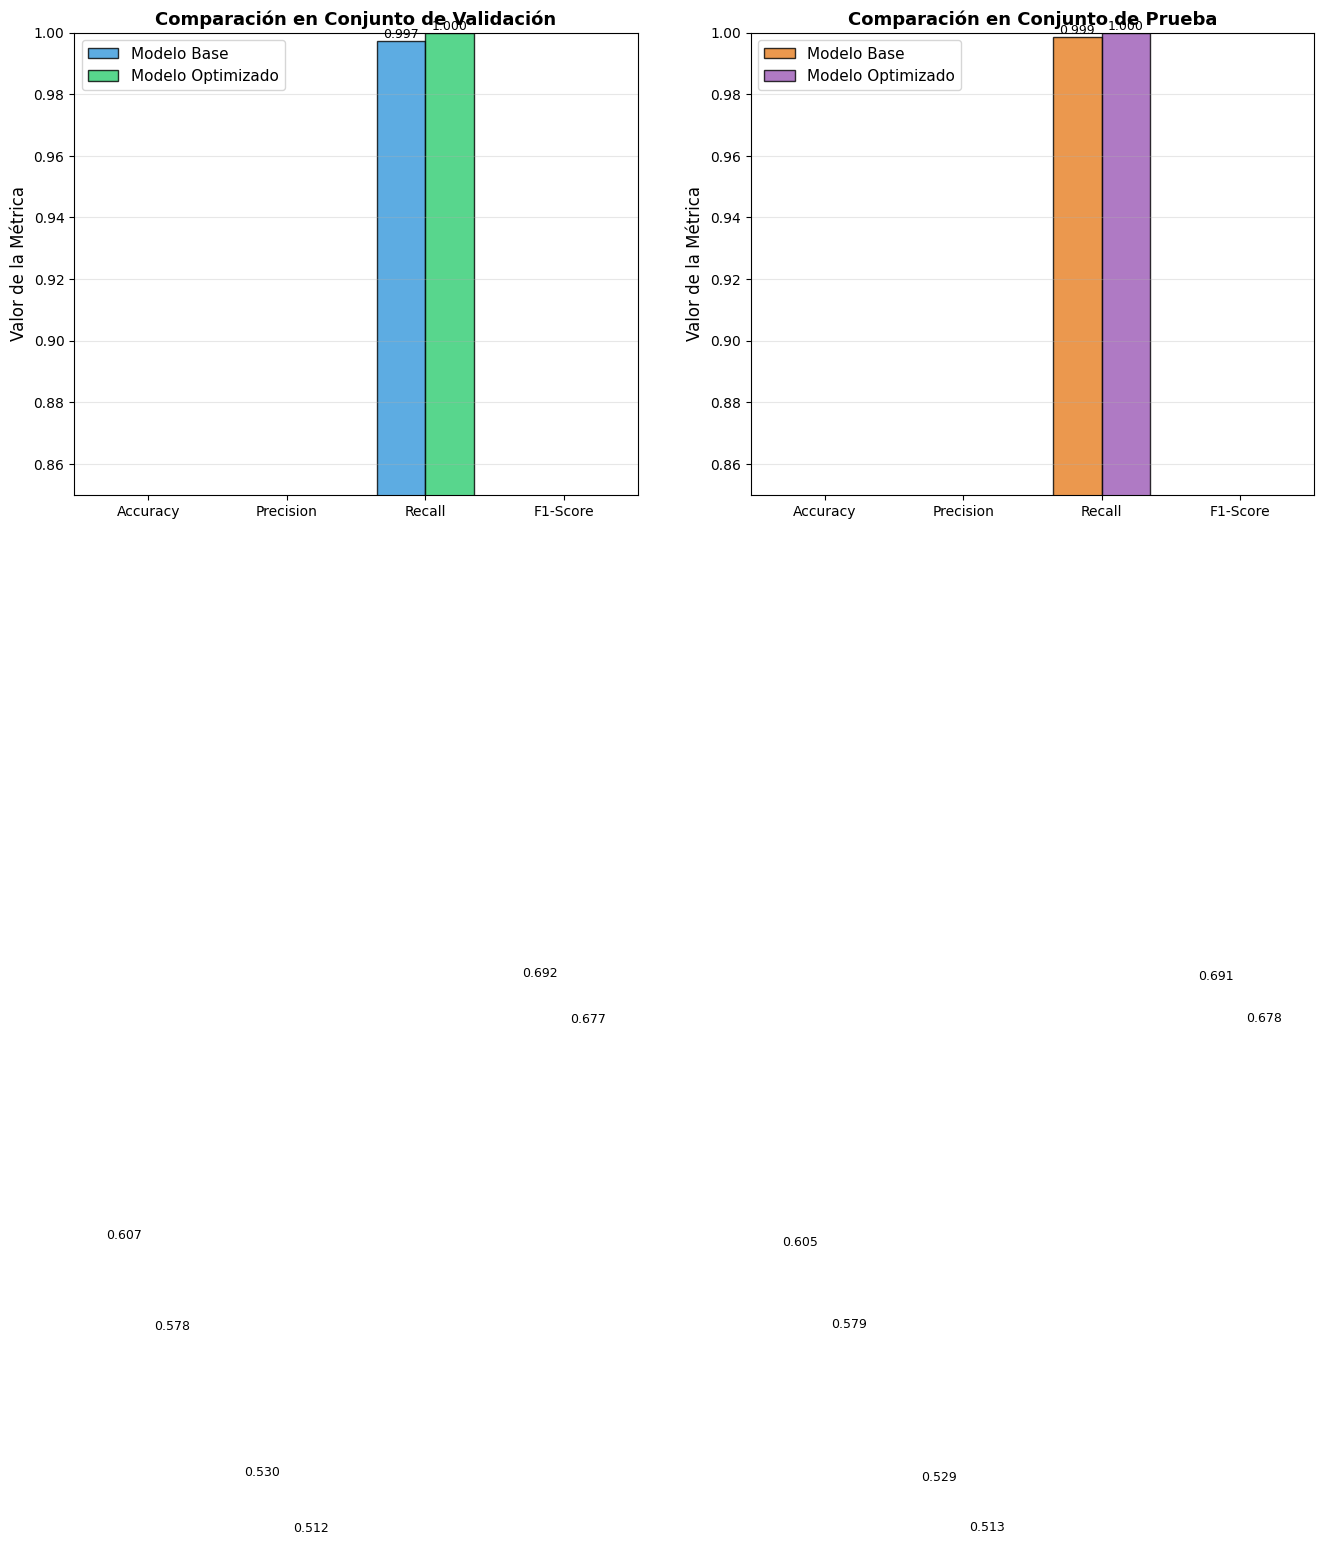

In [ ]:
# ============================================
# Visualización Comparativa de Métricas
# ============================================

# Crear gráfico comparativo de barras
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Datos para validación
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
base_val = [acc_val_base, prec_val_base, rec_val_base, f1_val_base]
opt_val = [acc_val_opt, prec_val_opt, rec_val_opt, f1_val_opt]

# Datos para prueba
base_test = [acc_test_base, prec_test_base, rec_test_base, f1_test_base]
opt_test = [acc_test_opt, prec_test_opt, rec_test_opt, f1_test_opt]

x = np.arange(len(metricas))
width = 0.35

# Gráfico de validación
bars1 = axes[0].bar(x - width/2, base_val, width, label='Modelo Base', 
                    color='#3498db', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, opt_val, width, label='Modelo Optimizado',
                    color='#2ecc71', alpha=0.8, edgecolor='black')

axes[0].set_ylabel('Valor de la Métrica', fontsize=12)
axes[0].set_title('Comparación en Conjunto de Validación', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metricas)
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.85, 1.0])

# Agregar valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Gráfico de prueba
bars3 = axes[1].bar(x - width/2, base_test, width, label='Modelo Base',
                    color='#e67e22', alpha=0.8, edgecolor='black')
bars4 = axes[1].bar(x + width/2, opt_test, width, label='Modelo Optimizado',
                    color='#9b59b6', alpha=0.8, edgecolor='black')

axes[1].set_ylabel('Valor de la Métrica', fontsize=12)
axes[1].set_title('Comparación en Conjunto de Prueba', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metricas)
axes[1].legend(fontsize=11)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.85, 1.0])

# Agregar valores en las barras
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# Análisis de Reducción de Errores
# ============================================

print("=" * 70)
print("ANÁLISIS DE REDUCCIÓN DE ERRORES")
print("=" * 70)

# Conjunto de Validación
fn_val_base = cm_val_base[0,1]  # phishing no detectado
fp_val_base = cm_val_base[1,0]  # legítimo marcado como phishing
fn_val_opt  = cm_val_opt[0,1]
fp_val_opt  = cm_val_opt[1,0]

# Conjunto de Prueba
fn_test_base = cm_test_base[0,1]
fp_test_base = cm_test_base[1,0]
fn_test_opt  = cm_test_opt[0,1]
fp_test_opt  = cm_test_opt[1,0]

print("\n📊 CONJUNTO DE VALIDACIÓN:")
print(f"\n  Falsos Negativos (FN) - Phishing no detectado (⚠ RIESGO):")
print(f"    - Modelo Base:       {fn_val_base}")
print(f"    - Modelo Optimizado: {fn_val_opt}")
print(f"    - Cambio:            {fn_val_base - fn_val_opt} ({((fn_val_base - fn_val_opt)/fn_val_base*100 if fn_val_base > 0 else 0):.2f}%)")

print(f"\n  Falsos Positivos (FP) - Legítimos marcados como phishing (falsas alarmas):")
print(f"    - Modelo Base:       {fp_val_base}")
print(f"    - Modelo Optimizado: {fp_val_opt}")
print(f"    - Cambio:            {fp_val_base - fp_val_opt} ({((fp_val_base - fp_val_opt)/fp_val_base*100 if fp_val_base > 0 else 0):.2f}%)")

print("\n" + "-" * 70)

print("\n📊 CONJUNTO DE PRUEBA:")
print(f"\n  Falsos Negativos (FN) - Phishing no detectado (⚠ RIESGO):")
print(f"    - Modelo Base:       {fn_test_base}")
print(f"    - Modelo Optimizado: {fn_test_opt}")
print(f"    - Cambio:            {fn_test_base - fn_test_opt} ({((fn_test_base - fn_test_opt)/fn_test_base*100 if fn_test_base > 0 else 0):.2f}%)")

print(f"\n  Falsos Positivos (FP) - Legítimos marcados como phishing (falsas alarmas):")
print(f"    - Modelo Base:       {fp_test_base}")
print(f"    - Modelo Optimizado: {fp_test_opt}")
print(f"    - Cambio:            {fp_test_base - fp_test_opt} ({((fp_test_base - fp_test_opt)/fp_test_base*100 if fp_test_base > 0 else 0):.2f}%)")


ANÁLISIS DE REDUCCIÓN DE ERRORES

📊 CONJUNTO DE VALIDACIÓN:

  Falsos Negativos (FN) - Phishing no detectado (⚠ RIESGO):
    - Modelo Base:       2
    - Modelo Optimizado: 0
    - Cambio:            2 (100.00%)

  Falsos Positivos (FP) - Legítimos marcados como phishing (falsas alarmas):
    - Modelo Base:       649
    - Modelo Optimizado: 700
    - Cambio:            -51 (-7.86%)

----------------------------------------------------------------------

📊 CONJUNTO DE PRUEBA:

  Falsos Negativos (FN) - Phishing no detectado (⚠ RIESGO):
    - Modelo Base:       1
    - Modelo Optimizado: 0
    - Cambio:            1 (100.00%)

  Falsos Positivos (FP) - Legítimos marcados como phishing (falsas alarmas):
    - Modelo Base:       654
    - Modelo Optimizado: 699
    - Cambio:            -45 (-6.88%)


In [ ]:
# ============================================
# Resumen y Conclusiones Finales
# ============================================

print("\n" + "=" * 70)
print("RESUMEN Y CONCLUSIONES FINALES")
print("=" * 70)

print("\n🔍 CONFIGURACIÓN DEL PROYECTO:")
print(f"  - Dataset: Training Dataset.arff")
print(f"  - Total de muestras: {len(df):,}")
print(f"  - Número de features: 30")
print(f"  - Variable objetivo: Result (-1=Phishing, 1=Legítimo)")
print(f"  - División de datos: 70% train, 15% validación, 15% prueba")
print(f"  - Semilla aleatoria: {RANDOM_STATE}")

print("\n🔬 MODELO BASE:")
print(f"  - Algoritmo: Gaussian Naive Bayes")
print(f"  - var_smoothing: {modelo_base.var_smoothing:.2e} (por defecto)")
print(f"  - F1-Score en prueba: {f1_test_base:.4f}")

print("\n🚀 MODELO OPTIMIZADO:")
print(f"  - Método de optimización: GridSearchCV")
print(f"  - var_smoothing óptimo: {grid_search.best_params_['var_smoothing']:.2e}")
print(f"  - F1-Score en validación cruzada: {grid_search.best_score_:.4f}")
print(f"  - F1-Score en prueba: {f1_test_opt:.4f}")

print("\n📈 MEJORA OBTENIDA:")
mejora_f1 = f1_test_opt - f1_test_base
mejora_f1_pct = (mejora_f1 / f1_test_base * 100)
print(f"  - Mejora en F1-Score: {mejora_f1:+.4f} ({mejora_f1_pct:+.2f}%)")

if mejora_f1 > 0.01:
    print("  ✓ La optimización mejoró significativamente el desempeño")
elif mejora_f1 > 0:
    print("  ✓ La optimización mejoró ligeramente el desempeño")
else:
    print("  - La optimización no generó mejoras significativas")

print("\n⚠ ANÁLISIS DE RIESGOS:")

# Corregido: el riesgo de "phishing no detectado" corresponde a FALSOS NEGATIVOS (FN)
fn_test_base = cm_test_base[0, 1]  # filas reales [-1,1], columnas predichas [-1,1]
fn_test_opt  = cm_test_opt[0, 1]

print(f"  - Falsos Negativos en prueba (Base): {fn_test_base} - Phishing no detectado")
print(f"  - Falsos Negativos en prueba (Optimizado): {fn_test_opt} - Phishing no detectado")

if fn_test_opt < fn_test_base:
    print(f"  ✓ Se redujo el riesgo de phishing no detectado en {fn_test_base - fn_test_opt} casos")
elif fn_test_opt > fn_test_base:
    print(f"  ⚠ Aumentó el riesgo de phishing no detectado en {fn_test_opt - fn_test_base} casos")
else:
    print("  - Sin cambios en falsos negativos (phishing no detectado)")

print("\n" + "=" * 70)
print("✅ PROYECTO COMPLETADO EXITOSAMENTE")
print("=" * 70)

print("\n📝 PRÓXIMOS PASOS SUGERIDOS:")
print("  1. Probar otros algoritmos (Random Forest, SVM, etc.)")
print("  2. Realizar ingeniería de features")
print("  3. Probar técnicas de ensamble")
print("  4. Analizar importancia de features")
print("  5. Implementar validación en datos del mundo real")



RESUMEN Y CONCLUSIONES FINALES

🔍 CONFIGURACIÓN DEL PROYECTO:
  - Dataset: Training Dataset.arff
  - Total de muestras: 11,055
  - Número de features: 30
  - Variable objetivo: Result (-1=Phishing, 1=Legítimo)
  - División de datos: 70% train, 15% validación, 15% prueba
  - Semilla aleatoria: 42

🔬 MODELO BASE:
  - Algoritmo: Gaussian Naive Bayes
  - var_smoothing: 1.00e-09 (por defecto)
  - F1-Score en prueba: 0.6915

🚀 MODELO OPTIMIZADO:
  - Método de optimización: GridSearchCV
  - var_smoothing óptimo: 1.00e-12
  - F1-Score en validación cruzada: 1.0000
  - F1-Score en prueba: 0.6777

📈 MEJORA OBTENIDA:
  - Mejora en F1-Score: -0.0137 (-1.99%)
  - La optimización no generó mejoras significativas

⚠ ANÁLISIS DE RIESGOS:
  - Falsos Negativos en prueba (Base): 1 - Phishing no detectado
  - Falsos Negativos en prueba (Optimizado): 0 - Phishing no detectado
  ✓ Se redujo el riesgo de phishing no detectado en 1 casos

✅ PROYECTO COMPLETADO EXITOSAMENTE

📝 PRÓXIMOS PASOS SUGERIDOS:
  1. P